# Classifying CIFAR10 images using ResNets, Regularization and Data Augmentation in PyTorch

### "Deep Learning with Pytorch "


Cifar10 데이터셋을 가지고 다음 테크닉을 적용해보겠습니다.

- Data normalization
- Data augmentation
- Residual connections
- Batch normalization
- Learning rate scheduling
- Weight Decay
- Gradient clipping
- Adam optimizer

In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

## CIFAR10 Dataset

PyTorch에서 CNN을 사용하는 이미지 분류 튜토리얼 예제 입니다.
약 75 % CIFAR10 데이터 세트의 이미지를 훈련 데이터로 이용했습니다.

다음은 데이터 세트의 이미지예제 입니다.

![cifar10](https://miro.medium.com/max/709/1*LyV7_xga4jUHdx4_jHk1PQ.png)


이전 튜토리얼에서했던 것처럼 데이터 세트를 다운로드하고 데이터를로드 할 PyTorch 데이터 세트를 생성하는 것으로 시작하겠습니다.

In [2]:
from torchvision.datasets.utils import download_url


# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')
    
# Look into the data directory
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)


['train', 'test']
['horse', 'airplane', 'frog', 'ship', 'deer', 'automobile', 'cat', 'bird', 'dog', 'truck']


torchvision의 ImageFolder 클래스를 사용하여 훈련 및 검증 데이터 세트를 생성 할 수 있습니다. ToTensor 변환 외에도 이미지에 다른 변환을 적용 할 것입니다. 

훈련 및 검증을 위해 PyTorch 데이터 세트를 생성하는 동안 몇 가지 중요한 변경 사항이 있습니다.

1. **검증을 위한 테스트 세트 데이터를 사용** : 검증을 위해 훈련 세트에서 데이터의 일부 (예 : 10 %)를 따로 설정하는 대신 테스트 세트를 검증 세트로 사용합니다. 이를 통하여 모델이 과적합되어 있는지 훈련상태를 확인할 수 있습니다.

2. **채널 별 데이터 정규화** : 평균을 빼고 각 채널의 표준 편차로 나누어 이미지 텐서를 정규화합니다. 결과적으로 각 채널의 데이터 평균은 0이고 표준 편차는 1입니다. 데이터를 정규화하면 다른 채널보다 더 높거나 더 넓은 범위의 값을 가짐으로써 한 채널의 값이 훈련하는 동안 손실 및 기울기에 불균형하게 영향을 미치는 것을 방지 할 수 있습니다.

<img src="https://i.imgur.com/LYxXBVg.png" width="360">


3. **무작위 데이터 증강 방식(data augmentation)**: 훈련 데이터세트에서 학습할 동안 무작위로 데이터를 변환을 적용하는 방식입니다. 예를들어 각 이미지를 4픽셀씩 채운다음 무작위로 잘라낸 다음 50% 확률로 이미지로 가로로 뒤집드는 등의 작업을 하는 방식을 의미합니다. 이를 통하여 각 에폭후 모델은 이미지를 잘 보게 될 수 있고 특징을 잘 추출하여 일반화할 수 있습니다.

![data-augmentation](https://imgaug.readthedocs.io/en/latest/_images/cropandpad_percent.jpg)

In [3]:
# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         # tt.RandomRotate
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [4]:
# PyTorch datasets
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)

Next, we can create data loaders for retrieving images in batches. We'll use a relatively large batch size of 500 to ut다음으로 이미지를 일괄 검색하기위한 데이터 로더를 만들 수 있습니다. 비교적 큰 배치 크기 인 500을 사용하여 GPU RAM의 더 많은 부분을 활용합니다. "메모리 부족"(Out of Memory)오류가 발생하면 배치 크기를 줄이고 커널을 다시 시작할 수 있습니다.

In [5]:
batch_size = 400

In [6]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


학습 DataLoader의 샘플 이미지를 살펴보도록 하겠습니다. 이미지를 표시하려면 픽셀값을 _denormalize_ 하여 `(0,1)`범위로 다시 가져와야 합니다.

In [7]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


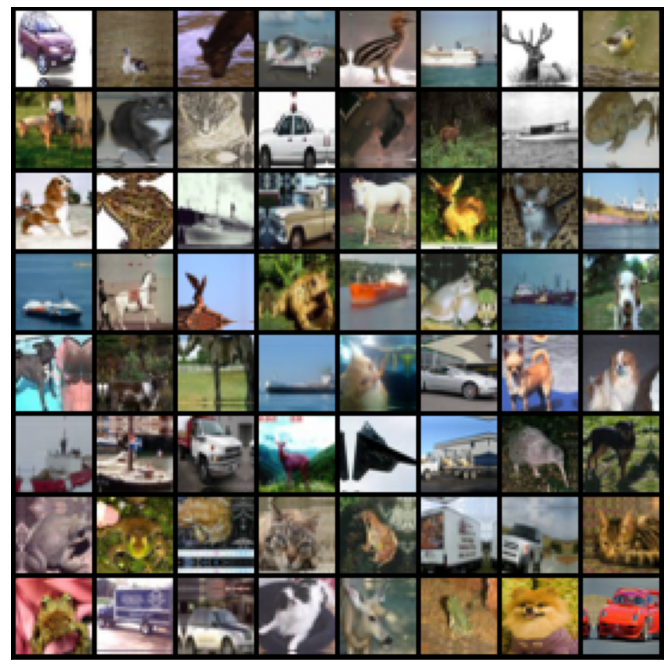

In [8]:
show_batch(train_dl)

정규화로 인하여 색상이 제대로 보이는지는 않는것 같습니다. 추론 중에도 제대로 보이는것 같습니다.일부 이미지에서 자르기 및 반사패딩을 볼 수 있스빈다. 수평 뒤집기는 감지하기가 약간 어렵습니다.

## GPU사용

GPU를 원활하게 사용하기 위해 사용 가능한 경우 몇 가지 도우미 함수 (`get_default_device` &`to_device`)와 도우미 클래스`DeviceDataLoader`를 정의하여 필요에 따라 모델 및 데이터를 GPU로 이동합니다.

In [9]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

실행하는 위치에 따라 기본 장치는 CPU (`torch.device ( 'cpu')`) 또는 GPU (`torch.device ( 'cuda')`) 일 수 있습니다.

In [10]:
device = get_default_device()
device

device(type='cpu')

이제 데이터 일괄 처리를 GPU (사용 가능한 경우)로 자동 전송하기 위해 'DeviceDataLoader'를 사용하여 학습 및 검증 데이터 로더를 래핑 할 수 있습니다.

In [11]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Model with Residual Blocks and Batch Normalization

이번에 CNN 모델의 주요 변경 사항 중 하나는 resudial 블록을 추가 한 것입니다.이 블록은 하나 이상의 컨벌루션 레이어를 통해 입력을 전달하여 얻은 출력 기능 맵에 원래 입력을 다시 추가합니다.

![](https://miro.medium.com/max/1140/1*D0F3UitQ2l5Q0Ak-tjEdJg.png)

잔차블록(Residual)의 예제 클래스입니다:

In [12]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

In [13]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
    out = simple_resnet(images)
    print(out.shape)
    break
    
del simple_resnet, images, labels
torch.cuda.empty_cache()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([400, 3, 32, 32])


이 작은 변화는 모델의 성능을 크게 향상시킵니다. 또한 각 컨벌루션 레이어 다음에 이전 레이어의 출력을 정규화하는 일괄 정규화 레이어를 추가합니다.

자세한 내용은 아래내용참고하면 더 좋은 내용을 얻을수 있습니다.

* 잔차블록이 어떻게 동작하는지: https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec
* 배치 정규화 및 드랍아웃 설명: https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd

우리는 [ResNet9](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet/) 모델을쓸겁니다.

![resnet-9](https://github.com/lambdal/cifar10-fast/raw/master/net.svg?sanitize=true)

In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [15]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [16]:
model = to_device(ResNet9(3, 10), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

## 모델 학습

학습전에, `fit` 함수를 수정할 것입니다:


* **Learning rate scheduling**: 기존의 학습속도를 고정하는 대신에 학습속도를 학습도중에 변경할 것입니다.
많은 변경방식이 있는데, 우리는 **"One Cycle Learning Rate Policy"**라고 불리는 방식을 할 것입니다.
이것은 낮은 학습속도로 시작해서 전체의 약 30% epochs에 도달하면 점차적으로 높은 학습속도로 바꾼다음 나머지 epoch에 대해 낮은 값으로 점차 감소시키는 방식
더 자세한 내용은 다음을 참고하세요!: https://sgugger.github.io/the-1cycle-policy.html

* **Weight decay**: 또한 손실 함수(Loss Function)에 추가 항(addtional Term)을 추가하여 가중치가 너무 커지는 것을 방지하는 또 다른 정규화 기술
더 자세한 내용은 다음을 참고하세요!: https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab

* **Gradient clipping**: 큰 기울기 값으로 인해 매개 변수가 너무많이 변경되는 것을 방지하기 위해 기울기 값을 작은 범위로 제한하는 기술
더 자세한 내용은 다음을 참고하세요!: https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48


Let's define a `fit_one_cycle` function to incorporate these changes. We'll also record the learning rate used for each batch.

In [17]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [18]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[{'val_acc': 0.08913461863994598, 'val_loss': 2.306379556655884}]

이제 모델을 훈련 할 준비가되었습니다. SGD (확률적 경사 하강법) 대신 momentum 및 adaptive learning rates과 같은 기술을 사용하는 Adam 최적화 프로그램을 사용하여 더 빠른 학습을 하고자 합니다. 여기에서 옵티 마이저에 대해 자세히 알아볼 수 있습니다.

optimizer에 대한 설명은 다음을 참고하세요!: https://ruder.io/optimizing-gradient-descent/index.html

In [19]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [20]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], last_lr: 0.00393, train_loss: 1.4887, val_loss: 1.8597, val_acc: 0.4531
Epoch [1], last_lr: 0.00935, train_loss: 1.0778, val_loss: 1.2285, val_acc: 0.6079


KeyboardInterrupt: ignored

In [ ]:
train_time='4:24'

우리 모델은 5 분 이내에 **90 % 이상의 정확도로 훈련되었습니다!** 데이터 증가, 네트워크 아키텍처 및 하이퍼 파라미터를 사용하여 다음과 같은 결과를 얻으십시오.

# 1. 10 분 이내에 94 % 정확도 (쉬움)
## 2. 2.5 분 이내에 90 % 정확도 (중급)
### 3. 5 분 이내에 94 % 정확도 (하드)

시간이 지남에 따라 모델이 어떻게 개선되는지 연구하기 위해 평가 세트 정확도를 플로팅 해 보겠습니다.

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
plot_accuracies(history)

학습 트렌드를 보기 연구하기 위해 훈련 및 검증 손실을 그래프를 띄워볼 수도 있습니다.

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
plot_losses(history)

위의 그래프에서 모델이 아직 훈련 데이터에 과적합되어 있지 않는 것같아 보입니다. 
배치 정규화, 데이터 증가 및 잔여 레이어를 하나씩 제거하여 과적합에 대한 영향을 연구를 해 보십시오.

마지막으로, 학습률이 시간이 지남에 따라 모든 시대에 걸쳐 배치별로 어떻게 변했는지 시각화해 보겠습니다.

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

In [ ]:
plot_lrs(history)

예상대로 학습률은 낮은 값에서 시작하여 반복의 30 %에서 최대 값 `0.01`까지 점진적으로 증가한 다음 점차 매우 작은 값으로 감소합니다.

## 이미지 테스트

지금까지 모델의 전체적인 정확도를 검증했지만 일부 샘플 이미지에서 모델의 결과를 보겠습니다. 
앞서 정의된 테스트 데이터 세트 10000개에 대한 이미지의 일부 이미지로 모델을 테스트해 보겠습니다.



In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

In [ ]:
img, label = valid_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
img, label = valid_ds[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', valid_ds.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
img, label = valid_ds[6153]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

모델의 성능이 저조한 부분을 식별하면 더 많은 학습 데이터를 수집하고 모델의 복잡성을 높이거나 낮추며 하이퍼 파라미터를 변경하여 모델을 개선하는 데 도움이 될 수 있습니다.

## Save

모델을 저장해 봅시다.

In [ ]:
torch.save(model.state_dict(), 'cifar10-resnet9.pth')

## 요약

딥러닝 모델을 처음부터 훈련해 보았습니다.

* **데이터 정규화(Data normalization)**: 평균을 빼고 각 채널에서 픽셀의 표준 편차로 나누어 이미지 텐서를 정규화했습니다. 데이터를 정규화하면 한 채널의 픽셀 값이 손실 및 기울기에 불균형하게 영향을 미치는 것을 방지 할 수 있습니다. [더 알아보기](https://medium.com/@ml_kid/what-is-transform-and-transform-normalize-lesson-4-neural-networks-in-pytorch-ca97842336bd)

* **데이터 증강기법(Data augmentation)**: 훈련 데이터 세트에서 이미지를 로드하는 동안 무작위 변환을 적용했습니다. 특히 각 이미지를 4 픽셀씩 채운다음 32 x 32 픽셀 크기의 무작위로 잘라낸 다음 50 % 확률로 이미지를 가로로 뒤집었습니다. [더 알아보기](https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/)

* **잔여 연결(Residual connections)**: CNN 모델의 주요 변경 사항 중 하나는 resudial 블록을 추가 한 것이 었는데, 이는 하나 이상의 컨벌루션 레이어를 통해 입력을 전달하여 얻은 출력 특성 맵에 원래 입력을 다시 추가하는 것입니다. ResNet9 아키텍처를 사용했습니다. [더 알아보기](https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec).

* **배치 정규화(Batch normalization)**: 각 컨벌루션 레이어 후에 이전 레이어의 출력을 정규화하는 배치 정규화 레이어를 추가했습니다. 이는 레이어의 출력에 적용되고 평균 및 표준 편차가 학습 된 매개 변수라는 점을 제외하면 데이터 정규화와 다소 유사합니다. [더 알아보기](https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd)

* **학습속도 스케줄링(Learning rate scheduling)**: 고정 학습률을 사용하는 대신 학습 스케줄러를 사용하여 모든 학습 배치후에 학습률을 변경했습니다. 훈련 중 학습률을 변경하기위한 많은 전략이 있으며 본 예제에서는 "1-Cycle-Policy"을 사용했습니다.[더 알아보기(https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) for varying the learning rate during training, and we used the "One Cycle Learning Rate Policy". [더 알아보기](https://sgugger.github.io/the-1cycle-policy.html)

* **가중치 감쇠(Weight Decay)**: 옵티 마이저에 weight decay를 추가했지만 손실 함수에 추가항을 추가하여 가중치가 너무 커지는 것을 방지하는 또 다른 기술입니다. [더 알아보기](https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab)

* **기울기 클리핑(Gradient clipping)**: 학습 도중 너무 큰 값의 변화를 막아 원치않은 범위의 그라디언트값을 가지도록 작은 범위로 제한하도록 하는 기술.  [더 알아보기](https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48#63e0)

* **아담 옵티마이저(Adam optimizer)**: SGD (stochastic gradient descent)대신에, momemtum이나 Adaptive Learning learning rate 같은 기술을 사용하는 Adam을 사용하여 더 빠른 학습이 되도록 하였습니다. 더 많은종류의 Optimizer를 알아보고 싶다면 [더 알아보기](https://ruder.io/optimizing-gradient-descent/index.html)


연습으로 각 기술을 독립적으로 적용하고 각 기술이 성능과 훈련 시간에 얼마나 영향을 미치는지 확인해야합니다. 
다양한 실험을 시도 할 때 올바른 아키텍처, 데이터 증강기법 및 정규화 기술을 선택하기위한 직관력을 기르기 시작해야 합니다.